# Introduction to text analytics seminar.

Author: Dr Stef Garasto.

Licence: [GPLv3](https://choosealicense.com/licenses/gpl-3.0/).


Python script to reproduce (approximately and partially) the paper ["Analyzing Gender Bias within Narrative Tropes"](https://aclanthology.org/2020.nlpcss-1.23.pdf) by Gala et al. (2020), part 1.

The goal is to show some useful text analytics techniques in context.

Specifically, we will see:

- some cleaning steps and a bit about regular expressions.
- extract and plot top terms in a collection of documents (using a count-based Bag of Words model).
- match specific keywords in a text.

In part 2, we will see:
- a bit about **approximate** matching of specific keywords in a text (using word embeddings).
- topic modelling using Latent Dirichlet Allocation.

These techniques are applied to try and quantify the **binary** "genderedness" of tropes and topics within those tropes.

Python-wise, this type of file is called a "Jupyter notebook", which is an interactive version of python. You can run small blocks of code, called cell, one at a time. One cell corresponds to one of those grey rectangle you see below.

If you click on a cell, you can run it by clicking SHIFT+ENTER.

You can also run all cells above and below a given one. To do this, click on the "Run" tab in the menu above and select the appropriate entry.

If anything goes wrong, chances are the "kernel" (basically, the python software) has been overloaded and stopper working. Try click on the "Run" tab in the menu above and select "Restart Kernel". Worst-case scenario, exit everything and start again.


In [1]:
!pip install cleantext

In [2]:
import numpy as np
import pandas as pd
import time
import requests
import os
import re
import cleantext
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import spacy


In [3]:
!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     ---------------------------------------- 0.1/12.8 MB 1.1 MB/s eta 0:00:13
     ---- ----------------------------------- 1.5/12.8 MB 12.2 MB/s eta 0:00:01
     ---------- ----------------------------- 3.5/12.8 MB 20.0 MB/s eta 0:00:01
     ---------------- ----------------------- 5.3/12.8 MB 23.9 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 26.5 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.8 MB 28.3 MB/s eta 0:00:01
     -------------------------------- ------ 10.6/12.8 MB 38.5 MB/s eta 0:00:01
     ------------------------------------- - 12.4/12.8 MB 38.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 34.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Data loading

In [4]:
data_folder = 'TVTropesData'
url_tropes= 'https://raw.githubusercontent.com/sg4gre/gre_ta_seminar_data/main/TVTropesData/tropes_v3.csv'
url_film_tropes = 'https://raw.githubusercontent.com/sg4gre/gre_ta_seminar_data/main/TVTropesData/film_imdb_match_v3.csv'
url_film_genres = 'https://raw.githubusercontent.com/sg4gre/gre_ta_seminar_data/main/TVTropesData/film_to_genres.csv'


In [5]:
# load tropes and example occurrences in films
tropes = pd.read_csv(url_tropes) #os.path.join(data_folder, 'tropes_v3.csv'))
film_tropes = pd.read_csv(url_film_tropes)
film_to_genre = pd.read_csv(url_film_genres)



In [6]:
tropes.head()

TropeID                       Trope  \
0  t00001               AbandonedArea   
1  t00002        AbandonedCatchphrase   
2  t00003           AbandonedHospital   
3  t00004  AbandonedHospitalAwakening   
4  t00005           AbandonedInfoPage   

                                         Description  
0  \nAbandoned places make good settings for fict...  
1  Catchphrases are a great and simple way to hel...  
2  The creepy abandoned hospital/mental instituti...  
3  An Abandoned Hospital Awakening is, as the nam...  
4  When a work is getting more and more complicat...

In [7]:
# how many tropes do we have?
len(tropes)

22554

In [8]:
tropes.sample(5, random_state=2)

TropeID                    Trope  \
6727   t09148         GladIThoughtOfIt   
20314  t27637              KillThemAll   
3927   t05339  DecemberDecemberRomance   
9044   t12335        KillEnemiesToOpen   
9742   t13255       LoveCanMakeYouGonk   

                                             Description  
6727   Bob and Alice have a problem. Bob has a brilli...  
20314  \nWhen Anyone Can Die becomes "Everyone Will D...  
3927   \nRomantic love that arises between two elderl...  
9044   A trope often seen in Video Games, these doors...  
9742   Warning signs of a character about become Gonk...

In [9]:
film_tropes.sample(5, random_state=45)

Title                  Trope  \
10440          Aquamarine  HeartbreakAndIceCream   
89306             Jumanji  PaintingTheFourthWall   
229723  YoungFrankenstein            AsideGlance   
134707    RoadToPerdition      BittersweetEnding   
68359          GranTorino         FirstNameBasis   

                                                  Example trope_id title_id  
10440    Aquamarine eats ice cream in the bath when it...   t09948     f858  
89306    When Peter starts hacking at a lock with an a...   t26963    f6499  
229723        Done several times in Young Frankenstein.\n   t01406   f16921  
134707     Michael Sr. dies, but the kid lives, and in...   t02336    f9980  
68359    When Walt allows the priest to use his name, ...   t08094    f5059

## Some data cleaning

In [10]:

# example problem - small spelling inconsistencies (compare "Back" and "back") where the trope is actually the same
print(tropes[['Trope','Description']].iloc[[5992,20022]].values)


[['Flashback'
  "A narrative technique in which we're shown events that took place before the episode's main action. Said events may have taken place on-screen earlier, but may also be new scenes depicting things hitherto only referenced.\nSpecific types of flashbacks include:\nSub-Trope of Separate Scene Storytelling. Dreaming of Times Gone By and Bad Dreams are two ways to show them. See also Flashback Effects for ways of distinguishing a Flash Back from normal action, and Viewers Are Goldfish for flashbacks to events that are still fresh in the audience's mind. It's also a brilliant way to indulge in some Exposition of Immortality. The inverse of this trope is the Flashforward, which depicts events in the future instead of the past.\nWhen a character is having a flashback, it can be because of psychic/magical powers, Post Traumatic Stress Disorder or simply resurfacing memories. In either case, it's a common justification for a movie to show the audience a Flashback.\nIf you want th

In [11]:
# other problem - presence of null values
film_tropes[film_tropes.Example.isna()].head(2)


Title                               Trope Example trope_id  \
103  ABeautifulMind  AllThereIsToKnowAboutTheCryingGame     NaN   t00635   
140   ABridgeTooFar                RealityIsUnrealistic     NaN   t18301   

    title_id  
103       f3  
140      f13

In [12]:
# drop all the NaN values where it matters
film_tropes = film_tropes.dropna(subset= ['Trope','Example'])
tropes = tropes.dropna(subset= ['Trope','Description'])


In [13]:
# make a copy of the Trope name and change to lowercase
film_tropes['TropeLower'] = film_tropes['Trope'].str.lower()

# now we can drop duplicates rows, those that contain the same example for the same trope
# note that if we wanted to be precise, 
# we'd drop the same example for the same trope *for the same film*
film_tropes = film_tropes.drop_duplicates(subset = ['Title', 'TropeLower','Example'])


In [14]:
# similarly drop duplicates contained in the list of tropes.
tropes['TropeLower'] = tropes['Trope'].str.lower()
 
# However, here there should be one and only one instance of each trope.
# So, we only use TropeLower as the subset
tropes = tropes.drop_duplicates(subset = ['TropeLower'])


In [15]:
tropes.head() # shows the first 5 rows of a dataframe


TropeID                       Trope  \
0  t00001               AbandonedArea   
1  t00002        AbandonedCatchphrase   
2  t00003           AbandonedHospital   
3  t00004  AbandonedHospitalAwakening   
4  t00005           AbandonedInfoPage   

                                         Description  \
0  \nAbandoned places make good settings for fict...   
1  Catchphrases are a great and simple way to hel...   
2  The creepy abandoned hospital/mental instituti...   
3  An Abandoned Hospital Awakening is, as the nam...   
4  When a work is getting more and more complicat...   

                   TropeLower  
0               abandonedarea  
1        abandonedcatchphrase  
2           abandonedhospital  
3  abandonedhospitalawakening  
4           abandonedinfopage

Finally, let's see some other useful cleaning step nicely summarised in one specialised python package called "cleantext". 


In [16]:
#useful package to automate some typical cleaning steps
def clean_my_text(x):
    cleaned_x = cleantext.clean(x,
        clean_all= False, # Execute all cleaning operations
        extra_spaces=True ,  # Remove extra white spaces 
        stemming=False , # Stem the words
        stopwords=True ,# Remove stop words
        lowercase=True ,# Convert to lowercase
        numbers=True ,# Remove all digits 
        punct=True ,# Remove all punctuations
        #reg: str = '<regex>', # Remove parts of text based on regex
        #reg_replace: str = '<replace_value>', # String to replace the regex used in reg
        stp_lang='english'  # Language for stop words
    )
    return cleaned_x



In [17]:
# let's apply it
tropes['Description'] = tropes['Description'].apply(clean_my_text)
film_tropes['Example'] = film_tropes['Example'].apply(clean_my_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [18]:
film_tropes.tail() # shows the LAST 5 rows of a dataframe

Title                       Trope  \
231024  Zygote           CanaryInACoalMine   
231025  Zygote                ScannableMan   
231026  Zygote  EerieArcticResearchStation   
231027  Zygote                 SciFiHorror   
231028  Zygote            ArtificialHumans   

                                                  Example trope_id title_id  \
231024  zygote canary class synthetics like barklay us...   t03153   f17016   
231025  zygote barklay barcode canary synthetic human ...   t19396   f17016   
231026  zygote set minutes future base mines asteroids...   t06556   f17016   
231027                                             zygote   t30297   f17016   
231028  subverted zygote mining corporations said comm...   t29424   f17016   

                        TropeLower  
231024           canaryinacoalmine  
231025                scannableman  
231026  eeriearcticresearchstation  
231027                 scifihorror  
231028            artificialhumans

## Some exploratory data analysis

Let's pause for a bit and let's explore the data a bit. Specifically, we will be looking at the distribution of unigrams and bi-grams.

So, what we are asking is the following: which words/tokens are the most common in our collection of documents? How about in the tropes titles only?

To do this, we need to use some nice functions from a python package called scikit-learn...


### Recap: n-grams and BoW models

An n-gram is a set of n contiguous tokens in a text. Creating n-grams assumes that we have already found a way to tokenize the text. For example, for the sentence:

"this is a text"

all the bi-grams would be:

["this is", "is a", "a text"].

We say unigram to indicate a single token. So, a collection of unigrams for the same sentence above would be:

["this", "is", "a", "text"].

The sklearn package contains two functions  `CountVectorizer` and `TfidfVectorizer` that allow us to transform a collection of documents into a Bag-of-Word model, using either token counts or TF-IDF scores.

The main role of the Bag-of-Word model is to transform text into a series of numbers that can be used as input to machine learning models. 

However, it can also be used to explore the dataset and obtain the most frequent n-grams for individual documents or the entire corpus.

`CountVectorizer` ([full documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)) has a few parameters of interest:

```
class sklearn.feature_extraction.text.CountVectorizer(corpus,
        tokenizer=None, ngram_range=(1, 1),
        max_df=1.0, min_df=1, max_features=None)
```

In order:
1. `tokenizer` determines how to split each document into tokens. It uses scikit-learn's own procedure, which basically consists of only splitting by blank spaces.
1. `ngram_range` determines the minimum and maximum number of contiguous tokens we want to consider. For example `ngram_range=(1,3)` means taking all unigrams, bigrams and trigrams. Note that if we write `ngram_range=(2,2)` then **only** bigrams are considered, while unigrams are discarded.
1. `max_df` determines the threshold to remove tokens that appear too often in the corpus. The higher it is, the fewer tokens are excluded. Specifically, this is the maximum proportion of documents a token can appear in to be kept. If it appears more often, it gets discarded.
1. `min_df` determines the threshold to remove tokens that are too infrequent. The lower it is, the fewer tokens are excluded. Specifically, this is the minimum number of documents that a token needs to appear in to be kept.
1. `max_features` allows us to only keep the most frequent n-grams.

The same arguments are also used for `TfidfVectorizer`.

Since we've already removed digits and punctuation, tokenization should be easier...


### Convert text into number and analyse most frequent n-grams

First, let's define a function to get the most frequent ngrams

In [19]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# define a function to get the most frequent ngrams
def get_top_ngram(corpus, ngram_range=(1,2), top_n= 50):
    '''
    The input is a collection of text documents, each represented by a list of tokens
    Exactly what we get out of the Spacy preprocessing
    By default it return the top 50 unigrams/bigrams
    '''
    # Let's create our CountVectorizer object
    # We set lowercase= False because we don't need to make tokens lowercase again
    # We set max_features to "top_n" because we only want the most common n-grams
    # ngram_range=(1,2) means that we ask CountVectorizer to create unigrams and bi-grams
    # We are using the default tokenizer (so, no need to specify it explicitely), but we need to be
    # specific about removing stop-words
    vec = CountVectorizer(ngram_range=ngram_range, max_features=top_n, lowercase=False,
                         stop_words='english')
    
    # We now fit the CountVectorizer to our corpus - this function creates the vocabulary
    # and counts how often each n-gram appears
    vec.fit(corpus)
    # get a vector for each document
    bag_of_words = vec.transform(corpus)
    # sum across documents
    sum_words = bag_of_words.sum(axis=0)
    # get the words with their frequencies
    # the attribute .vocabulary stores all the n-grams in the vocabulary, indexed by a number
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    # sort them by frequency
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse= True)
    # separate the n_grams from their frequencies
    ngram_labels = [word[0] for word in words_freq]
    ngram_freqs = [word[1] for word in words_freq]
    # return the results
    return bag_of_words, ngram_freqs, ngram_labels


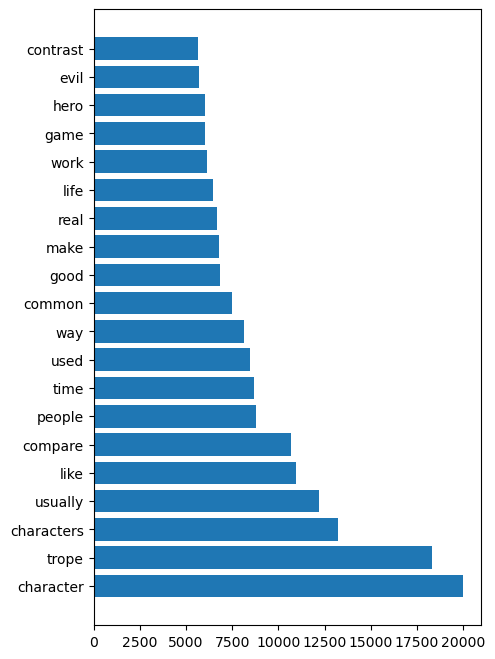

In [20]:
# let's get the n-gram frequencies
bag_of_words, ngram_freqs, ngram_labels = get_top_ngram(tropes['Description'],
                                                        ngram_range=(1,2), top_n= 20)

# let's plot them (most common ones are at the bottom)
plt.figure(figsize=(5,8))
_ = plt.barh(y=range(20), width=ngram_freqs,tick_label=ngram_labels)


### Excercise

They're not too bad. But, these are pretty much all unigrams. That is because single tokens are much more frequent than pairs of tokens. Perhaps we can show the bi-grams separately?

(Also note "characters" and "character", which shuold be joined. This issue should be taken care of using lemmatization, however scikit-learn's CountVectorizer does **not** include lemmatization by default).

Let's get just the bigrams - how would you modify the code below to achieve this?

Remember that ngram_range determines the minimum and maximum number of contiguous tokens we want to consider. For example ngram_range=(1,3) means taking all unigrams, bigrams and trigrams.

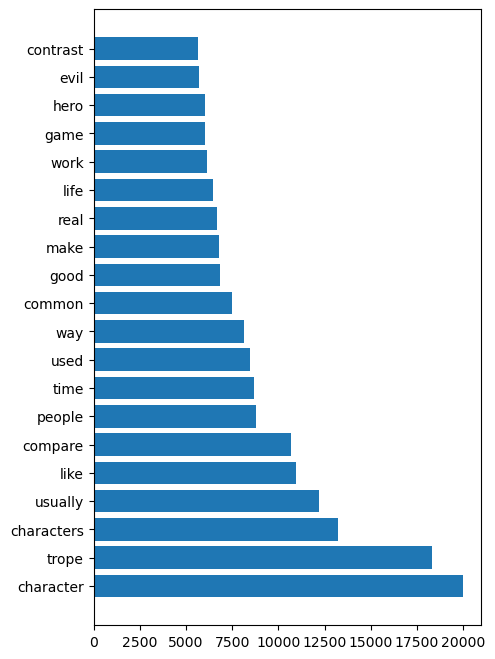

In [21]:
# let's get the n-gram frequencies (ONLY 2-grams this time)
bag_of_words, ngram_freqs, ngram_labels = get_top_ngram(tropes['Description'],
                                                        ngram_range=(1,2), top_n= 20)

# let's plot them (most common ones are at the bottom)
plt.figure(figsize=(5, 8))
_ = plt.barh(y=range(20),width=ngram_freqs,tick_label=ngram_labels)

# Measuring trope genderedness

The goal is to quantify how much each trope is gendered (in a binary way) towards "male" or "female" concepts (not an objective reality! More correctly, we'd say how much each trope contains words that are typically associated with men and women and therefore can be perceived by people as being more or less gendered in a certain - binary - way).

To do this, following the paper we will:
1. Represent a trope by its description and ALL its examples.
2. Find the number of occurrences for "female" and "male" words.
3. Compute a "local" ratio for each trope.


In [22]:
# First, we need to group all examples of tropes in films by the trope and join all of them up
film_tropes['AllExamples'] = film_tropes.groupby('TropeLower')['Example'].transform(
    lambda x: ' '.join(x))


In [23]:
# you can see in the last columns that all occurrences of the same trope have the same "AllExamples" entry
film_tropes[film_tropes.TropeLower=='cliffhanger'].head()

Title        Trope  \
23005            Bolt  CliffHanger   
23472      BossNigger  CliffHanger   
30409       Carnosaur  CliffHanger   
79319   IfAManAnswers  CliffHanger   
101160   MacheteKills  CliffHanger   

                                                  Example trope_id title_id  \
23005   created order make show within show appealing ...   t03882    f1742   
23472   film ends boss gets shot multiple times may dy...   t03882    f1782   
30409   third movies ending reveals dinosaurs ship sol...   t03882    f2175   
79319   dont know called chantal telephone end know wa...   t03882    f5970   
101160  machete stops missiles voz escapes space soldi...   t03882    f7485   

         TropeLower                                        AllExamples  
23005   cliffhanger  created order make show within show appealing ...  
23472   cliffhanger  created order make show within show appealing ...  
30409   cliffhanger  created order make show within show appealing ...  
79319   cliffhanger  created order make show within show appealing ...  
101160  cliffhanger  created order make show within show appealing ...

In [24]:
# let's retain only tropes and examples
# we can drop the duplicates
tropes_and_examples = film_tropes[['TropeLower','AllExamples']].drop_duplicates()
tropes_and_examples.head()


TropeLower                                        AllExamples
0          msfanservice  concert segments make clear agnetha fridas loo...
1  insistentterminology  radio station manager tasks ashley delivering ...
2        deadpansnarker  band moments one crowning examples agnethas re...
3          dayinthelife  film follows abba tour clerks mallrats clerks ...
4        themetunecameo  brief snippet knowing knowing well dum dum did...

In [25]:
# now let's join up the dataframes so that each trope gets the full list of examples
# we join on TropeLower so we are not derailed by spelling mistakes
augmented_tropes = pd.merge(tropes, tropes_and_examples, left_on = 'TropeLower', right_on = 'TropeLower',
                           how= 'left')
augmented_tropes['DescAndExamples'] = augmented_tropes['Description'] + ' ' + augmented_tropes['AllExamples'].fillna('')


In [26]:
# let's see the results - there should be two extra columns
augmented_tropes.sample(3, random_state = 42)

TropeID                   Trope  \
423    t00563                Allegory   
3522   t04793  CrossCulturalHandshake   
15067  t20462            SkeleBot9000   

                                             Description  \
423    allegory work thats designed metaphor somethin...   
3522   shaking hands isnt culturespecific habit sure ...   
15067  visual trope science fiction materials humanoi...   

                   TropeLower  \
423                  allegory   
3522   crossculturalhandshake   
15067            skelebot9000   

                                             AllExamples  \
423    eventually becomes clear chan less individual ...   
3522                                                 NaN   
15067  advanced mechas ending highly evolved robots e...   

                                         DescAndExamples  
423    allegory work thats designed metaphor somethin...  
3522   shaking hands isnt culturespecific habit sure ...  
15067  visual trope science fiction materials humanoi...

Let's load the list of words that we will use to quantify the perceived and binary genderdeness of tropes.

Source for the lists of words: https://github.com/uclanlp/gn_glove/tree/master/wordlist.


In [27]:
# data loading
with open('male_word_file.txt') as f:
    male_words = f.read()
male_words = male_words.split('\n')
    
print(male_words[:3])

# data loading
with open('female_word_file.txt') as f:
    female_words = f.read()
female_words = female_words.split('\n')
print(female_words[:3])


['countryman', 'fraternal', 'wizards']
['countrywoman', 'sororal', 'witches']


### Count all occurrences of male and female terms in each augmented trope.

We will use Spacy to make this easy.

[Reference: [spaCy 101](https://spacy.io/usage/spacy-101#whats-spacy)]

spaCy is a free, open-source python library for advanced NLP, designed specifically for production use. This means that it's optimized to "get things done" by making some decisions on behalf of the user, based on the latest research and on what spaCy's developers determined was the best trade-off. This generally means slightly less flexibility and a bit more efficiency.

spaCy is mostly based on "trained pipelines", similarly to what we saw with scikit-learn's pipelines. These are collections of ordered components that use previously trained statistical models to process a text dataset. For example, the tokenizer is part of a pipeline.

Trained pipelines are behind spaCy's features and capabilities.

The most important feature in the pipeline is, as mentioned, the tokenizer, which is used to split a text document into its constituent tokens. Tokens are often, but not always, equivalent to individual words and symbols. Thinking in terms of tokens allows us to consider each text as a different ordered sequence of a limited number of tokens. Indeed, the set of all unique tokens used across all documents in our dataset is called the "vocabulary".

When working with english text there are three main pipeline often used. These have been trained on the same web data, but are based on statistical models of different sizes. Generally, larger models are more accurate but slower. The pipeline names are:

1. `en_core_web_sm`: this is the pipeline with the smallest models. Start here to see if this is powerful enough.
2. `en_core_web_md`: medium models: use them if you need more powerful models.
3. `en_core_web_lg`: largest models: use them if you need the most powerful models (that is, nothing else is working).

These pipelines work with the English language, but Spacy also has pipelines for other languages!

In [28]:
nlp = spacy.load("en_core_web_sm")

#### A note on Tokenization

To count the top n-grams we have used scikit-learn tokenizer, while now we will use Spacy's.

Each tokenizer will act slightly differently. spaCy [tokenizes](https://spacy.io/usage/spacy-101#annotations-token) a text by following a rule-based algorithm, looking for contiguous portions of alpha-numeric characters. This means it ignores punctuation by default and would, for example, keep "we've" as "we've" (initially!). It also has a rule though that "we've" should be split as "we", "'" and "ve". The specific rules depends on the language we are using.

The advantage of using Spacy is that we have more flexibility in how we tokenize **and** we can also lemmatize a text. Scikit-learn doesn't offer lemmatization by default. The disadvantage is that using Spacy is slower. Both can handle stop words.

Here, we use different libraries because each of them (sklearn and Spacy) have different specialties, so it's easier to use for some things but not for others.

For some projects, though, it may be important to use the same tokenizer throughout. To do this, one would need to modify some of the building block or arguments of the functions used, but it is possible to use Spacy tokenizer together with sklearn CountVectorizer. One option, which is a bit slow to compute, is to use Spacy to tokenize and lemmatize each document, save the results and use that text representation throughout.



In [29]:
# this is going to take a few minutes, it's normal!
t0= time.time()
docs = list(nlp.pipe(augmented_tropes['DescAndExamples'], 
            ##disabling NLP capabilities that are irrelevant for the task at hand can speed things up
           disable=["tok2vec","ner","parser","textcat"])) 
print(f'Overall it took {(time.time()-t0)/60:.3f} minutes.')


Overall it took 3.179 minutes.


In [30]:
# let's explore Spacy's capabilities a bit
for i,token in enumerate(docs[1]):
    print('The original token is: ', token)
    print("It's lemmatized version is: ", token.lemma_)
    print('Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) :', token.is_stop)
    print()
    if i>9:
        break
        

The original token is:  catchphrases
It's lemmatized version is:  catchphrases
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  great
It's lemmatized version is:  great
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  simple
It's lemmatized version is:  simple
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  way
It's lemmatized version is:  way
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  help
It's lemmatized version is:  help
Is it a stop word? (We removed some before, but Spacy might have a different list of stop words) : False

The original token is:  characters
It's lemmatized version is:  characters
Is it a stop word? (We removed some before, but Spacy might 

In [31]:
from spacy.matcher import PhraseMatcher # this is what we need to find specific patterns of words in a text.

# PhraseMatcher is used with these following steps:
# 1. create an instance of PhraseMatcher (one for each list of words to match)
# 2. process the list of words to match using a minimal processing pipeline 
# (this is because Spacy always works with text processed through one of its pipelines)
# 3. Add the processed list of words to the matcher.


male_matcher = PhraseMatcher(nlp.vocab)
# As per Spacy's suggestion, we only run nlp.make_doc() instead of nlp() to speed things up 
# (minimal pipeline with little more than the tokenizer)
male_patterns = [nlp.make_doc(text) for text in male_words]
male_matcher.add("TerminologyList", male_patterns)

female_matcher = PhraseMatcher(nlp.vocab)
female_patterns = [nlp.make_doc(text) for text in female_words]
female_matcher.add("TerminologyList", female_patterns)


def match_gendered_terms(matcher, trope):
    # Function to apply a matcher to a given document (trope).
    # It finds all the relevant words and only returns how many there are
    trope_doc = trope
    matches = matcher(trope_doc)
    return len(matches)

    

In [32]:

t0 = time.time()
female_tokens_nb = []
male_tokens_nb = []
for doc in docs:
    # for each document (a trope) match all "male" and "female" words and count how many we found
    female_tokens_nb.append(match_gendered_terms(female_matcher,doc))
    male_tokens_nb.append(match_gendered_terms(male_matcher,doc))
    
print(f'Overall it took {time.time()-t0:.2f} seconds')

# store everything in a dataframe
augmented_tropes['FemaleTokensNb'] = female_tokens_nb
augmented_tropes['MaleTokensNb'] = male_tokens_nb


Overall it took 0.52 seconds


### Compute a "genderedness" ratio.

From the paper:
The raw genderedness score of trope i is the ratio:

\begin{equation}
d_{trope} = \frac{f(trope)}{f(trope) + m(trope)} / \frac{f(tropes)}{f(tropes) + m(tropes)}
\end{equation}

This score is a trope’s proportion of female tokens among gendered tokens, normalized by the global ratio in the corpus. If $d_{trope}$ is high, that trope contains a larger-than-usual proportion of female words.

We finally calculate the the genderedness score $g_{trope}$ as $d_{trope}$’s normalized z-score. This results in scores from −negative (male-dominated) to positive (female-dominated) values. For our analyses, we consider tropes with genderedness scores outside of [−1, 1]
(one standard deviation) to be highly gendered (see Table 2 for examples). 

While similar to methods used in prior work (Garcia et al., 2014), our genderedness score is limited by its lexicon and susceptible to gender generalization and explicit marking (Hitti et al.,2019). We leave exploration of more nuanced methods of capturing trope genderedness (Ananya et al.,2019) to future work.


In [33]:
# Find the "female" proportion of matches across ALL tokens
total_male_matches = augmented_tropes['MaleTokensNb'].sum()
total_female_matches = augmented_tropes['FemaleTokensNb'].sum()
r_tropes = total_female_matches / (total_male_matches + total_female_matches)
print(f'The global ratio is {r_tropes:.2}')

The global ratio is 0.31


In [34]:
# Get some more statistics that will be helpful later

# number of tokens in each trope
augmented_tropes['TokensNb'] = [len(doc) for doc in docs]

# number of gendered tokens (total and split)
augmented_tropes['GenderedTokensNb']= augmented_tropes['FemaleTokensNb'] + augmented_tropes['MaleTokensNb']

augmented_tropes['MaleTokensRatio'] = augmented_tropes['MaleTokensNb']/augmented_tropes['TokensNb']
augmented_tropes['FemaleTokensRatio'] = augmented_tropes['FemaleTokensNb']/augmented_tropes['TokensNb']


In [35]:
from sklearn.preprocessing import StandardScaler

# compute the local proportion of female tokens for a trope
augmented_tropes['fm_ratio'] = augmented_tropes['FemaleTokensNb']/(
    augmented_tropes['FemaleTokensNb']+augmented_tropes['MaleTokensNb'])

# divide by the global ratio
augmented_tropes['raw_gender_score']= augmented_tropes['fm_ratio']/r_tropes

# set tropes where no gendered token at all was found to Not A Number
augmented_tropes.loc[((augmented_tropes['MaleTokensNb']==0) & (augmented_tropes['FemaleTokensNb']==0)),
                    'raw_gender_score'] == pd.NA

# standardize the scores (that is, subtract the average score across tropes and divide by the standard deviation)
scaler= StandardScaler()
augmented_tropes['gender_score']= scaler.fit_transform(augmented_tropes[['raw_gender_score']])


In [36]:
# Some tropes are more noise than signal.
# For some things, we'll only keep tropes with at least 300 tokens and with at least 1% of gendered terms
tokens_th = 300 # this is 1000 in the paper, but they also use a larger dataset
ratio_th = 0.01
filtered_tropes = (augmented_tropes['TokensNb']>tokens_th) & (
    augmented_tropes['GenderedTokensNb']/augmented_tropes['TokensNb']>ratio_th)


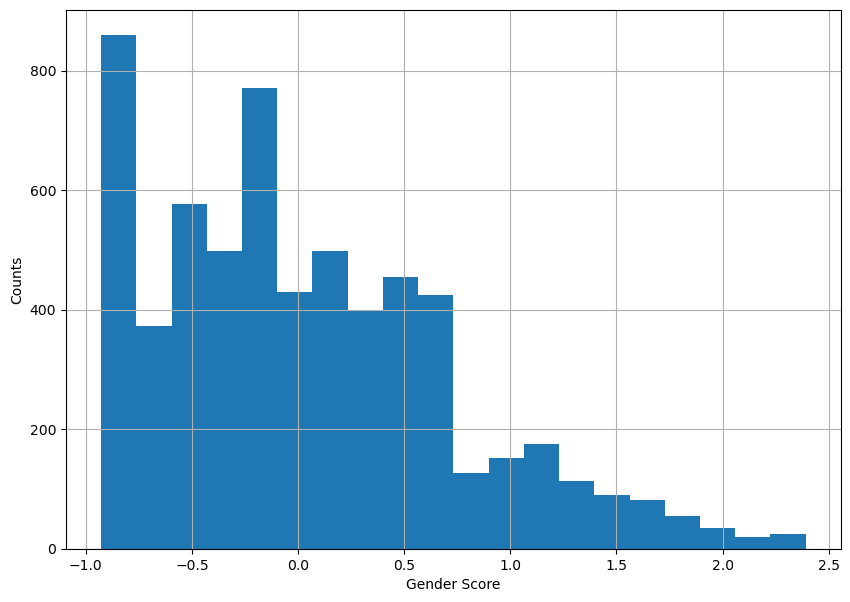

In [37]:
# histogram of the scaled ratio: what is the distribution of scores across the filtered tropes?
ax = augmented_tropes.loc[filtered_tropes, 'gender_score'].hist(bins=20, figsize = (8,4))
ax.set_xlabel('Gender Score')
_=ax.set_ylabel('Counts')


Which tropes have the most extreme gender scores?


In [39]:
# let's sort to have lowest score at the top ("Male-dominated tropes")
# This is achieved using the "sort values" function:
# by = [X, Y] means sort the rows first based on the values in the column X, then based on the values in the column Y.
# Also possible to give one column only (or more than 2)
# "ascending" controls whether we want the results in increasing (True) or decreasing (False) order. We can setup a different behaviour for each column.
# So, here, for example we are first sorting by gender_score in increasing order. 
# For rows with the same gender score, we are then sorting them in decreasing order of the absolute number of male tokens.

augmented_tropes.loc[filtered_tropes, ['gender_score','GenderedTokensNb','FemaleTokensNb','MaleTokensNb',
                                       'FemaleTokensRatio','MaleTokensRatio',
                                      'TokensNb','Description']].sort_values(by = ['gender_score','MaleTokensNb'],
                                                               ascending=[True,False]).head()



gender_score  GenderedTokensNb  FemaleTokensNb  MaleTokensNb  \
16161      -0.92772                61               0            61   
6768       -0.92772                51               0            51   
14827      -0.92772                48               0            48   
6654       -0.92772                43               0            43   
14573      -0.92772                42               0            42   

       FemaleTokensRatio  MaleTokensRatio  TokensNb  \
16161                0.0         0.018385      3318   
6768                 0.0         0.062271       819   
14827                0.0         0.019810      2423   
6654                 0.0         0.030935      1390   
14573                0.0         0.031019      1354   

                                             Description  
16161  superheroes try make world safer innocents lon...  
6768   man upstairs pretty cool guy wants people happ...  
14827  believe villain doesnt realize simply shoot he...  
6654   minion henchman big strong tough ordinary mook...  
14573  hero spared burden dispatching villain villain...

In [40]:
# let's sort again to have highest score at the top ("Female-dominated tropes")
augmented_tropes.loc[filtered_tropes, ['Trope','gender_score','GenderedTokensNb','FemaleTokensNb','MaleTokensNb',
                                       'FemaleTokensRatio','MaleTokensRatio',
                                      'TokensNb','Description']].sort_values(by = ['gender_score','FemaleTokensNb'],
                                                               ascending=False).head()



gender_score  GenderedTokensNb  FemaleTokensNb  MaleTokensNb  \
19217      2.391259                53              53             0   
20992      2.391259                43              43             0   
6907       2.391259                25              25             0   
11804      2.391259                13              13             0   
12683      2.391259                12              12             0   

       FemaleTokensRatio  MaleTokensRatio  TokensNb  \
19217           0.109731              0.0       483   
20992           0.114667              0.0       375   
6907            0.070423              0.0       355   
11804           0.035326              0.0       368   
12683           0.033994              0.0       353   

                                             Description  
19217  welcome dark side classic witch step lightly m...  
20992  welcome dark side classic witch step lightly m...  
6907   lady wearing purple sign femininity whether gi...  
11804  know fetal alcohol syndrome irreversible brain...  
12683  characters fair hair seen frequently expected ...

#### Excercise

What if we wanted to see the top 5 tropes with the highest absolute number of "Female Tokens", without taking into account ? How would we need to modify the code below?


In [47]:
# let's sort again to have highest score at the top ("Female-dominated tropes")
augmented_tropes.loc[filtered_tropes, ['Trope','gender_score','GenderedTokensNb','FemaleTokensNb','MaleTokensNb',
                                       'FemaleTokensRatio','MaleTokensRatio',
                                      'TokensNb','Description']].sort_values(by = ['FemaleTokensNb'],
                                                               ascending=False).head()

Trope  gender_score  GenderedTokensNb  FemaleTokensNb  \
14872     ShoutOut      0.060986               950             283   
20636   SilentFilm      0.118966               742             234   
20268  SilentMovie      0.118966               742             234   
10474   MissingMom      1.451477               279             200   
253      AdultFear      0.659247               389             186   

       MaleTokensNb  FemaleTokensRatio  MaleTokensRatio  TokensNb  \
14872           667           0.007105         0.016745     39832   
20636           508           0.025831         0.056077      9059   
20268           508           0.025630         0.055641      9130   
10474            79           0.099751         0.039401      2005   
253             203           0.020836         0.022740      8927   

                                             Description  
14872  shoutout something name line dialogue prop sho...  
20636  film spoken dialogue late technological limita...  
20268  film spoken dialogue late technological limita...  
10474  perhaps died perhaps left theres bitterness in...  
253    adult fears things mature welladjusted adults ...

### Genderedness by film genre
 
How about the "genderedeness" of two specific genres? (Action and Romance)

In [41]:
# match films to genres
# we only have two genres because IMBD data is not publicly available (it's "public", but not open source), 
# so I did some (limited!) manual matching

# check the genre distribution
film_to_genre.Genre.value_counts()


romance    29
action     15
Name: Genre, dtype: int64

In [42]:
# let's join the films we have with their genre (for some, at least)
augmented_film_tropes = pd.merge(film_tropes, 
                                 augmented_tropes[['TropeLower','gender_score','GenderedTokensNb',
                                                   'FemaleTokensNb','MaleTokensNb','TokensNb']],
                                how='left', left_on = 'TropeLower', right_on= 'TropeLower')

# we do this by matching using the lowercase film title
augmented_film_tropes['TitleLower'] = augmented_film_tropes['Title'].str.lower()
augmented_film_tropes = pd.merge(augmented_film_tropes,
                                film_to_genre,
                                how= 'right', left_on = 'TitleLower', right_on= 'TitleLower')


In [43]:
# Let's see what the average and the standard deviation of the Gender ratio is for the two different genres
# Remember that negative values mean higher than average Male Tokens
# Positive values mean higher than average Female Tokens

# "groupby" collects all rows with the same genre. Then, for each group we only select the "gender score" column
# "agg" performs some aggregation over all rows with the same genre. Here, we are computing the average gender_score across all rows in a genre group.
augmented_film_tropes.groupby('Genre')['gender_score'].agg(['mean','std'])


mean       std
Genre                      
action  -0.069075  0.745373
romance  0.228107  0.728776

#### Exercise

How would we modify the code below to compute the average number of Female Tokens (FemaleTokensNb) by genre, and the standard deviation of the same?


In [49]:
augmented_film_tropes.groupby('Genre')['gender_score'].agg(['mean','std'])


mean        std
Genre                        
action    8.464652  18.889142
romance  13.059429  23.910518

In [44]:
augmented_tropes[filtered_tropes][['Trope','DescAndExamples',
                                   'gender_score','GenderedTokensNb']].to_csv('partial_augmented_tropes.csv', index= False)


#### Exercise (bit more advanced)

How do we need to complete the code below to see the top trope within romance film with the highest gender score?


In [53]:
augmented_film_tropes[augmented_film_tropes.Genre==?].?(by=[?], ?=?).head(1)


Title         Trope  \
1460  LoveActually  WhenHeSmiles   

                                                Example trope_id title_id  \
1460  aurelia love actually commentary richard curti...   t28398    f7377   

        TropeLower                                        AllExamples  \
1460  whenhesmiles  completely subverted addams family values perp...   

      gender_score  GenderedTokensNb  FemaleTokensNb  MaleTokensNb  TokensNb  \
1460      2.391259               4.0             4.0           0.0     278.0   

        TitleLower    Genre  
1460  loveactually  romance

#### Exercise

How about completing the code below to see the romance film ordered by decreasing average gender score?

In [56]:
tmp = augmented_film_tropes[augmented_film_tropes.Genre==?].?(?)['gender_score'].?([?])
tmp.sort_values(ascending = False)#.head(1)
                                                                      

Title
MeBeforeYou             0.603955
CallMeByYourName        0.547903
Blended                 0.547382
TheParentTrap1998       0.491677
JustGoWithIt            0.387770
Ghost1990               0.357411
LoveActually            0.351652
MyBigFatGreekWedding    0.269611
ThePrincessBride        0.266874
Titanic1997             0.185941
ForrestGump            -0.039761
GoodWillHunting        -0.047543
Name: gender_score, dtype: float64